# Vortex Plots

Integrative analysis across peak sets and datasets.

**Inputs:**
1. List of peak sets
2. Config of samples, bigwig path and class of sample (each class will have same plot styling). If sample belongs to ATAC dataset, old cluster ID else NA.
3. For each cluster, colour, description, new cluster number (set to same as original if it should not be changed)

In [2]:
library(ggplot2)
library(patchwork)
library(reshape2)
library(rtracklayer)
library(scales)
library(viridis)
library(matrixStats)
library(raster)

Loading required package: sp


Attaching package: ‘sp’


The following object is masked from ‘package:IRanges’:

    %over%



Attaching package: ‘raster’


The following object is masked from ‘package:rtracklayer’:

    values


The following objects are masked from ‘package:GenomicRanges’:

    distance, shift, trim, values, values<-


The following objects are masked from ‘package:IRanges’:

    distance, shift, trim, values, values<-


The following objects are masked from ‘package:S4Vectors’:

    metadata, metadata<-, values, values<-


The following object is masked from ‘package:patchwork’:

    area




## Loading Inputs

### Configs

In [4]:
vortex_config = read.table("./vortex_tracks_config.tsv", sep='\t', header=T, stringsAsFactors = F)
vortex_config$type = factor(vortex_config$type)
vortex_config

title,short_name,old_cluster,type,group,width,path
<chr>,<chr>,<int>,<fct>,<int>,<int>,<chr>
Fibroblast,Fib,1,ATAC,1,2000,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20210714_n64913/croo/cluster_idx1/signal/rep1/cluster_idx1.fc.signal.bigwig
Fibroblast,Fib,NA,H3K4me2,1,4000,/oak/stanford/groups/akundaje/surag/GEO/GSE62777/croo/hiF-T_P15_H3K4me2/signal/pooled-rep/basename_prefix.pooled_x_SRR2106008.nodup.fc.signal.bigwig
High OSK,High,11,ATAC,2,2000,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20210714_n64913/croo/cluster_idx11/signal/rep1/cluster_idx11.fc.signal.bigwig
Low OSK,Low,15,ATAC,2,2000,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20210714_n64913/croo/cluster_idx15/signal/rep1/cluster_idx15.fc.signal.bigwig
OCT4,OCT4,NA,ChIP,2,2000,/oak/stanford/groups/akundaje/surag/GEO/GSE36570/croo/SRR445816/signal/rep1/SRR445816.filt_x_ctl_for_rep1.fc.signal.bigwig
SOX2,SOX2,NA,ChIP,2,2000,/oak/stanford/groups/akundaje/surag/GEO/GSE36570/croo/SRR445817/signal/rep1/SRR445817.filt_x_ctl_for_rep1.fc.signal.bigwig
KLF4,KLF4,NA,ChIP,2,2000,/oak/stanford/groups/akundaje/surag/GEO/GSE36570/croo/SRR445818/signal/rep1/SRR445818.filt_x_ctl_for_rep1.fc.signal.bigwig
cMYC,cMYC,NA,ChIP,2,2000,/oak/stanford/groups/akundaje/surag/GEO/GSE36570/croo/SRR445819/signal/rep1/SRR445819.filt_x_ctl_for_rep1.fc.signal.bigwig
Intermediate,Int,14,ATAC,3,2000,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20210714_n64913/croo/cluster_idx14/signal/rep1/cluster_idx14.fc.signal.bigwig


In [3]:
# manually add if required
# vortex_config[15,] = c("iPSC", 18, "ATAC", 4, 2000, 
#                        "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20200518_n76052/croo/cluster_idx18/signal/rep1/cluster_idx18.fc.signal.bigwig")

# vortex_config$old_cluster = as.integer(vortex_config$old_cluster)
# vortex_config$width = as.integer(vortex_config$width)

In [5]:
peak_set_config = read.table("./vortex_peak_set_config.tsv", stringsAsFactors = F, comment.char = '', sep='\t', header=T)
peak_set_config

title,group,path
<chr>,<int>,<chr>
P6,1,/users/surag/kundajelab/scATAC-reprog/src/analysis/20200307_fine_clustering/beds/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/idx6.bed
P7,1,/users/surag/kundajelab/scATAC-reprog/src/analysis/20200307_fine_clustering/beds/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/idx7.bed
P8,1,/users/surag/kundajelab/scATAC-reprog/src/analysis/20200307_fine_clustering/beds/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/idx8.bed
E-ON,1,/users/surag/kundajelab/scATAC-reprog/src/figures_factory/Fig5/early_on.bed


In [6]:
cluster_config = read.table("../configs/cluster.tsv", comment.char = '', header=T, sep='\t')
cluster_config$colour = as.character(cluster_config$colour)
cluster_config$description = as.character(cluster_config$description)

rownames(cluster_config) = cluster_config$cluster
cluster_config

,cluster,colour,description,new_cluster
,<int>,<chr>,<chr>,<int>
1,1,#B03743,Fibroblast,1
2,2,#E85F6D,Fibroblast-like,3
3,3,#7C2730,Fibroblast-like,2
4,4,#F0A118,Intermediate,12
5,5,#78A824,Pre-iPSC,13
6,6,#A6D854,Pre-iPSC,14
7,7,#F01D35,Fibroblast-like,5
8,8,#13C4A3,iPSC,15
9,9,#406614,Partially-reprogrammed,10


### Peak Sets

In [7]:
peak_sets = list()
SUBSAMPLE = 10

for (i in seq(nrow(peak_set_config))) {
    peak_sets[[i]] = import(peak_set_config[i, "path"])
    peak_sets[[i]] = peak_sets[[i]][seq(1,length(peak_sets[[i]]),SUBSAMPLE)]
}

In [8]:
# manually load peaks
# peak_sets = list()
# peak_sets[[1]] = import("/users/surag/kundajelab/scATAC-reprog/resources/GSE101074/TFAP2C.dependent.reg.elements.hg38.bed")
# peak_sets[[1]] = peak_sets[[1]][seq(1,length(peak_sets[[1]]),5)]

# peak_sets[[2]] = import("/users/surag/kundajelab/scATAC-reprog/resources/GSE101074/naive.specific.atac.hg38.bed")
# peak_sets[[2]] = peak_sets[[2]][seq(1,length(peak_sets[[2]]),5)]

# peak_sets[[3]] = import("/users/surag/kundajelab/scATAC-reprog/resources/GSE101074/primed.specific.atac.hg38.bed")
# peak_sets[[3]] = peak_sets[[3]][seq(1,length(peak_sets[[3]]),5)]

In [9]:
peak_set_lens = list()

for (i in seq(length(peak_sets))) {
    peak_set_lens[[i]] = length(peak_sets[[i]])
}

peak_set_lens

sum(unlist(peak_set_lens))

[[1]]
[1] 3022

[[2]]
[1] 2350

[[3]]
[1] 2755

[[4]]
[1] 861

[1] 8988

### Fetch Data from BigWigs

In [10]:
get_matrix_from_bigwig <- function(bigwig_path, peak_set) {
    # ensure peak set has fixed width
    stopifnot(length(unique(width(peak_set)))==1)
    
    as.matrix(import(bigwig_path, 
      which=peak_set, as="NumericList"))
}

In [11]:
matrices = list()

In [12]:
for (i in seq(length(peak_sets))) {
    matrices[[i]] = list()
    
    for (j in seq(nrow(vortex_config))) {
        matrices[[i]][[j]] = get_matrix_from_bigwig(vortex_config[j, "path"], 
                                                    resize(peak_sets[[i]], width=vortex_config[j, "width"], fix='center'))
    }
}

## Compute Orders for Each Peak Set and Reorder

In [13]:
# samples which will be used to decide peak order (based on mean signal across all)
ROW_ORDER_TYPE = "ATAC"

In [14]:
peak_set_orders = list()

In [15]:
for (i in seq(length(peak_sets))) {
    tmp_matrix = do.call(cbind, matrices[[i]][vortex_config$type %in% ROW_ORDER_TYPE])
    peak_set_orders[[i]] = order(rowSums(tmp_matrix))
}

In [16]:
rm(tmp_matrix)

In [17]:
peak_set_orders[[1]][1:10]

[1] 1254  644 1029  726 2180 1007 1407 2664 2025 1624

In [18]:
for (i in seq(length(peak_sets))) {
    for (j in seq(nrow(vortex_config))) {
        matrices[[i]][[j]] = matrices[[i]][[j]][peak_set_orders[[i]], ]
    }
}

## Smooth Samples

In [19]:
y_lims = list()

In [20]:
# find limits for clipping
for (k in seq(length(unique(vortex_config$type)))) {
    type = unique(vortex_config$type)[k]
    
    tmp_matrices = list()
    
    # collapse across time points
    for (i in seq(length(peak_sets))) {
        tmp_matrices[[i]] = do.call(cbind, matrices[[i]][vortex_config$type %in% type])
    }
    
    # collapse across peak sets
    tmp_matrices = do.call(rbind, tmp_matrices)    
    
    y_lims[[type]] = as.numeric(quantile(tmp_matrices, 0.98))
    
}

In [21]:
rm(tmp_matrices)

In [22]:
y_lims

[[1]]
[1] 8.14165

[[2]]
[1] 4.87927

[[3]]
[1] 5.84078

In [23]:
# clip matrices to y_lim
clipped_matrices = list()

for (i in seq(length(peak_sets))) {
    clipped_matrices[[i]] = list()
    
    for (j in seq(nrow(vortex_config))) {
        clipped_matrices[[i]][[j]] = matrices[[i]][[j]]
        clipped_matrices[[i]][[j]][clipped_matrices[[i]][[j]] > y_lims[[vortex_config[j, "type"]]]] = y_lims[[vortex_config[j, "type"]]]
    }
}

In [24]:
create_sum_matrix <- function(n, r) {
  suppressWarnings(matrix(c(rep(1, r), rep(0, n)), n, n/r))
}

In [25]:
# mean downsample matrices along X dimension 
# ENSURE DIM_AFTER_SAMPLE is a divisor of all widths
DIM_AFTER_SAMPLE = 200

smoothed_matrices = list()
for (i in seq(length(peak_sets))) {
    smoothed_matrices[[i]] = list()
    
    for (j in seq(nrow(vortex_config))) {
            stopifnot(ncol(clipped_matrices[[i]][[j]])%%DIM_AFTER_SAMPLE==0)

            scale_factor = ncol(clipped_matrices[[i]][[j]])/DIM_AFTER_SAMPLE
            smoothed_matrices[[i]][[j]] = (1/scale_factor)*(clipped_matrices[[i]][[j]]%*%create_sum_matrix(ncol(clipped_matrices[[i]][[j]]), scale_factor))
    }
}

In [26]:
# mean downsample along samples (y-axis)

Y_SUBSAMPLE_FACTOR = 5
for (i in seq(length(peak_sets))) {
    for (j in seq(nrow(vortex_config))) {
            smoothed_matrices[[i]][[j]] = t((1/Y_SUBSAMPLE_FACTOR)*(t(smoothed_matrices[[i]][[j]])%*%create_sum_matrix(nrow(smoothed_matrices[[i]][[j]]), 
                                                                                                                     Y_SUBSAMPLE_FACTOR)))
    }
}

In [27]:
dim(smoothed_matrices[[1]][[1]])

[1] 604 200

In [28]:
# additional smoothing
# for (i in seq(length(peak_sets))) {
#     for (j in seq(nrow(vortex_config))) {
#         smoothed_matrices[[i]][[j]] =  as.matrix(focal(raster(smoothed_matrices[[i]][[j]]), matrix(1, 3, 3), mean, pad = T, padValue = 0))
#     }
# }

## Decide Limits and Colour Schemes

In [29]:
COLORSCALES = list(scale_fill_viridis_c(option="B", oob=squish), 
               scale_fill_distiller(palette="Blues", oob=squish, direction=1),
               scale_fill_distiller(palette="Reds", oob=squish, direction=1))

In [50]:
# decide limits for each type
for (k in seq(length(unique(vortex_config$type)))) {
    type = unique(vortex_config$type)[k]
    
    tmp_matrices = list()
    
    # collapse across time points
    for (i in seq(length(peak_sets))) {
        tmp_matrices[[i]] = do.call(cbind, smoothed_matrices[[i]][vortex_config$type %in% type])
    }
    
    # collapse across peak sets
    tmp_matrices = do.call(rbind, tmp_matrices)
    
    low = quantile(tmp_matrices, 0.01)
    high = quantile(tmp_matrices, 0.999)
    
    COLORSCALES[[k]]$limits = c(low, high)
    
}

In [54]:
rm(tmp_matrices)

In [51]:
for (k in seq(length(unique(vortex_config$type)))) {
    print(COLORSCALES[[k]]$limits)
}

      1%    99.9% 
0.028012 8.065601 
      1%    99.9% 
0.000000 4.757816 
      1%    99.9% 
0.126842 3.583393 


In [33]:
# manual adjustment for ChIP-seq
COLORSCALES[[2]]$limits = c(0.5, 3)

## Plotting

In [34]:
plot_vortex <- function(bwmatrix, color_scale_with_limits,
                       title=NULL, clust_name=NULL, ticks=NULL) {
    # ticks is a number and if not null, will make ticks at
    # left and right end with +ticks kb and -ticks kb
    
    melted = melt(bwmatrix)
    
    plot <- ggplot(melted, aes(x=Var2, y= Var1, fill=value)) +
#     geom_tile_rast() + # kinda slow, geom_raster is faster and smaller files
#     geom_tile() +
    geom_raster() +
    color_scale_with_limits + 
    scale_y_continuous(expand = c(0, 0)) + # this removes whitespace between plot and border
    theme_void() 
    
    if (!is.null(title)) {
        plot = plot + ggtitle(title) +
        theme(plot.title = element_text(hjust = 0.5))
    }
    
    if (!is.null(clust_name)) {
        plot = plot + ylab(sprintf("%s ", clust_name)) + 
             theme(axis.title.y = element_text())
    }
    
    if (!is.null(ticks)) {
        plot = plot + scale_x_continuous(breaks = c(1, ncol(bwmatrix)/2, ncol(bwmatrix)), 
                                         labels = c(sprintf("-%dkb", ticks), "",
                                                    sprintf("+%dkb", ticks)),
                                         expand = c(0,0)) # this removes whitespace between plot and border
        plot = plot + theme(axis.ticks.length=unit(.25, "cm"),
                           axis.text.x = element_text(size=10))
    }
                                         
    else {
        plot = plot + 
               scale_x_continuous(expand=c(0,0)) + # this removes whitespace between plot and border
               theme(axis.ticks.x=element_blank(),
                    axis.text.x = element_blank(),) 
    }
    
    plot = plot + theme(legend.position = "none",             
            axis.title.x = element_blank(),
#             axis.text.y=element_blank(),
            axis.line=element_blank(),
            axis.ticks.y=element_blank(),
            plot.margin = unit(c(0,2,0,2), "pt"), # right tick label was clipping
          panel.border = element_rect(colour = "black", fill=NA, size=0.5))
    
    plot
}

In [35]:
# bwm_clipped = bwm
# bwm_clipped[bwm_clipped>quantile(bwm, 0.99)] = quantile(bwm, 0.99)
# bwm_clipped_ordered = bwm_clipped[order(rowMeans(bwm)), ]
# bwm_clipped_smoothed = as.matrix(focal(raster(bwm_clipped_ordered), matrix(1, 11, 3), mean, pad = T, padValue = 0))
# quantile(bwm_clipped_smoothed, c(0.95, 0.98, .99,.999, .9999, 1))
# vortex_plot <- plot_vortex(bwm_clipped_smoothed[1:100,], scale_fill_distiller(palette = "Reds"))

In [36]:
all_plots = list()
row_widths = list()

In [37]:
X_SPACER_WIDTH = 0
X_NON_SPACER_WIDTH = -0.15

for (i in seq(length(peak_sets))) {
    tot_plots = 1
    all_plots[[i]] = list()
    
    for (j in seq(nrow(vortex_config))) {
        if (j>1) {
            all_plots[[i]][[tot_plots]] = plot_spacer() # spacing between every consecutive plot
            
            if (vortex_config[j,"group"]!=vortex_config[j-1,"group"]) {
            row_widths[[tot_plots]] = X_SPACER_WIDTH # spacing between groups
            }
            else {
                row_widths[[tot_plots]] = X_NON_SPACER_WIDTH # spacing within groups
            }
            
            tot_plots = tot_plots + 1
        }
        
        title = NULL
        ticks = NULL
        clust_name = NULL
        if (i==1) {
            title = vortex_config[j, "short_name"]
        }
        
        if (j==1) {
            clust_name = peak_set_config$title[i]
        }
        # TODO: ticks mess margins
#         else if (i==length(peak_sets)) {
#             ticks = vortex_config[j, "width"]/2000
#         }
        
        all_plots[[i]][[tot_plots]] = plot_vortex(smoothed_matrices[[i]][[j]][seq(1, nrow(smoothed_matrices[[i]][[j]]), 1),],
                                         COLORSCALES[[as.numeric(vortex_config[j, "type"])]],
                                                 title=title,
                                                 clust_name=clust_name,
                                                 ticks=ticks)
        row_widths[[tot_plots]] = 1
        tot_plots = tot_plots + 1
    }
}

In [38]:
Y_SPACER_WIDTH = -0.1
Y_NON_SPACER_WIDTH = -0.2

rowwise_plots = list()
col_heights = list()
tot_plots = 1

for (i in seq(length(peak_sets))) {
    if (i>1) {
        rowwise_plots[[tot_plots]] = plot_spacer() # spacing between groups
        
        if (peak_set_config[i,"group"]!=peak_set_config[i-1,"group"]) {
            col_heights[[tot_plots]] = Y_SPACER_WIDTH*mean(unlist(peak_set_lens)) # spacing between groups
        }
        else {
            col_heights[[tot_plots]] = Y_NON_SPACER_WIDTH*mean(unlist(peak_set_lens)) # spacing within groups
        }
        
        tot_plots = tot_plots + 1
    }
    
    rowwise_plots[[tot_plots]] =  wrap_plots(all_plots[[i]], nrow = 1, widths = row_widths)
    col_heights[[tot_plots]] = peak_set_lens[[i]]
    
    tot_plots = tot_plots + 1
}

In [39]:
length(row_widths)
length(col_heights)

[1] 31

[1] 7

In [40]:
length(all_plots[[1]])
length(rowwise_plots)
# length(all_plots[[2]])

[1] 31

[1] 7

### Assemble Integration

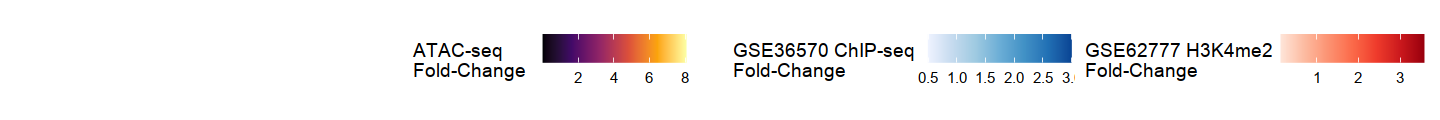

In [41]:
# legends
legend_titles = c("ATAC-seq  \nFold-Change  ",
                 "GSE36570 ChIP-seq  \nFold-Change  ",
                 "GSE62777 H3K4me2  \nFold-Change  ")
legends = list()

for (k in seq(length(unique(vortex_config$type)))) {
    legends[[k]] = cowplot::get_legend(ggplot(data = data.frame(Var1=c(1), Var2=c(1), value=c(1)), 
                   aes(x = Var2, y = Var1, fill = value)) +
            geom_raster() +  
            COLORSCALES[[k]] +
            labs(fill=legend_titles[k]) +
            theme(legend.position = "bottom"))
}

options(repr.plot.width = 12, repr.plot.height = 1)

legend_plot = wrap_plots(plot_spacer(), wrap_plots(legends, nrow=1), widths=c(1,3))
legend_plot

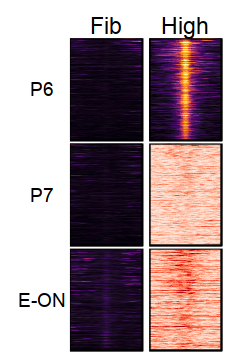

In [42]:
options(repr.plot.width = 2, repr.plot.height = 3)

wrap_plots(wrap_plots(all_plots[[1]][[1]],all_plots[[1]][[5]],nrow=1),
           plot_spacer(),
           wrap_plots(all_plots[[2]][[1]],all_plots[[2]][[3]],nrow=1),
           plot_spacer(),
           wrap_plots(all_plots[[4]][[1]],all_plots[[4]][[3]],nrow=1)
           , ncol=1, heights=c(1,-0.15,1,-0.15,1)) 

In [43]:
top_annotate_plot = ggplot() + 
                theme_void() +
                geom_line() +
                coord_cartesian(xlim = c(0.5,9.5), # this let's use 0-10 on x axis to place items
                               ylim=c(0,10)) + # this let's use 0-10 on y axis to place items
                annotate("segment", x = 0, xend = 1.2, y = 2, yend = 2, size=1, colour = "black") +
                annotate("text", x = .6, y = 5, size=5, label = "Fibroblasts") +

                annotate("segment", x = 1.3, xend = 4.9, y = 2, yend = 2, size=1, colour = "black") +
                annotate("text", x = 3.15, y = 5, size=5, label = "D2") +

                annotate("segment", x = 5, xend = 6.8, y = 2, yend = 2, size=1, colour = "black") +
                annotate("text", x = 6, y = 5, size=5, label = "D4-D8") +

                annotate("segment", x = 6.9, xend = 8.7, y = 2, yend = 2, size=1, colour = "black") +
                annotate("text", x = 7.85, y = 5, size=5, label = "D10-D24") +

                annotate("segment", x = 8.8, xend = 10, y = 2, yend = 2, size=1, colour = "black")  +
                annotate("text", x = 9.4, y = 5, size=5, label = "iPSC") 
#                 annotate("text", x = 2, y = 25, label = "Some text")

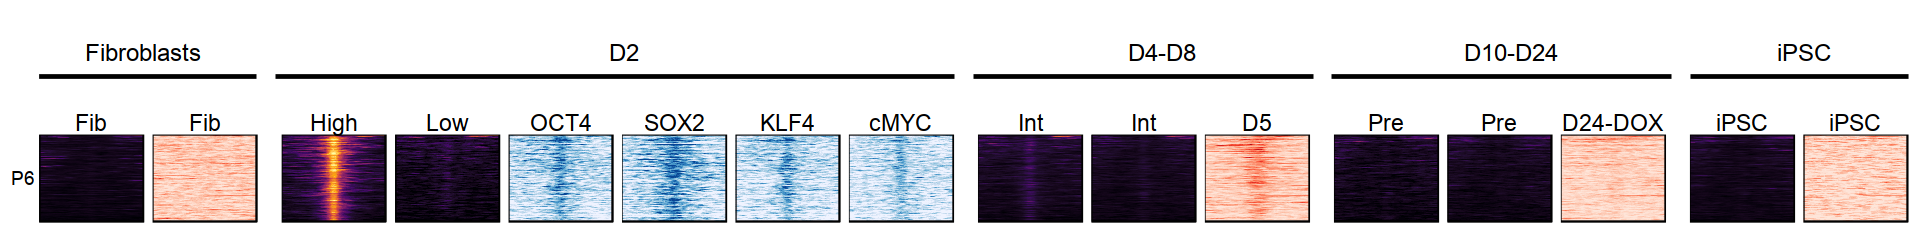

In [44]:
options(repr.plot.width = 16, repr.plot.height = 2)

wrap_plots(top_annotate_plot,
           rowwise_plots[[1]],
           heights=c(1,1))

In [45]:
# left_annotate_plot = ggplot() + 
#                 theme_void() +
#                 geom_line() +
#                 coord_cartesian(xlim = c(0.5,9.5), # this let's use 0-10 on x axis to place items
#                                ylim=c(0.5,9.5)) + # this let's use 0-10 on y axis to place items
#                 annotate("segment", x = 8, xend = 8, y = 0, yend = 2.7, size=1, colour = "black") +
#                 annotate("text", x = 5, y =1.35, size=5, angle=90, label = "Close Open") +

#                 annotate("segment", x = 8, xend = 8, y = 2.8, yend = 6.6, size=1, colour = "black") +
#                 annotate("text", x = 5, y = 4.7, size=5, angle=90, label = "Transient") +

#                 annotate("segment", x = 8, xend = 8, y = 6.7, yend = 10, size=1, colour = "black")  +
#                 annotate("text", x = 5, y = 8.35, size=5, angle=90, label = "Open Close") 
# #                 annotate("text", x = 2, y = 25, label = "Some text")

In [46]:

# options(repr.plot.width = 2, repr.plot.height = 10.5)


# first_col = list()
# for (j in seq(length(rowwise_plots))) {
#    if ("spacer" %in% class(rowwise_plots[[j]])) {
#       first_col[[j]] = plot_spacer()
#    }
#    else {
#        first_col[[j]] = rowwise_plots[[j]][[1]]    
#     }
# }
# first_col_plot = wrap_plots(first_col, 
#                            heights=col_heights)

# wrap_plots(left_annotate_plot,
#            first_col_plot,
#            widths=c(1,1))

In [47]:
# options(repr.plot.width = 13, repr.plot.height = 9)
# vortex_grid = wrap_plots(
#     rowwise_plots,
#     ncol=1,
#     heights = col_heights)

# vortex_grid_w_left_anno = wrap_plots(left_annotate_plot, 
#                                      vortex_grid,
#                                     widths=c(1,12))

# top_annotate_plot_w_space = wrap_plots(plot_spacer(),
#                                        top_annotate_plot,
#                                       widths=c(1,9)) # adjust to account for cluster numbers text

# complete_plot = wrap_plots(top_annotate_plot_w_space,
#                                         vortex_grid_w_left_anno,
#                                         legend_plot,
#                                         heights=c(0.5,7.5, 1))
# complete_plot

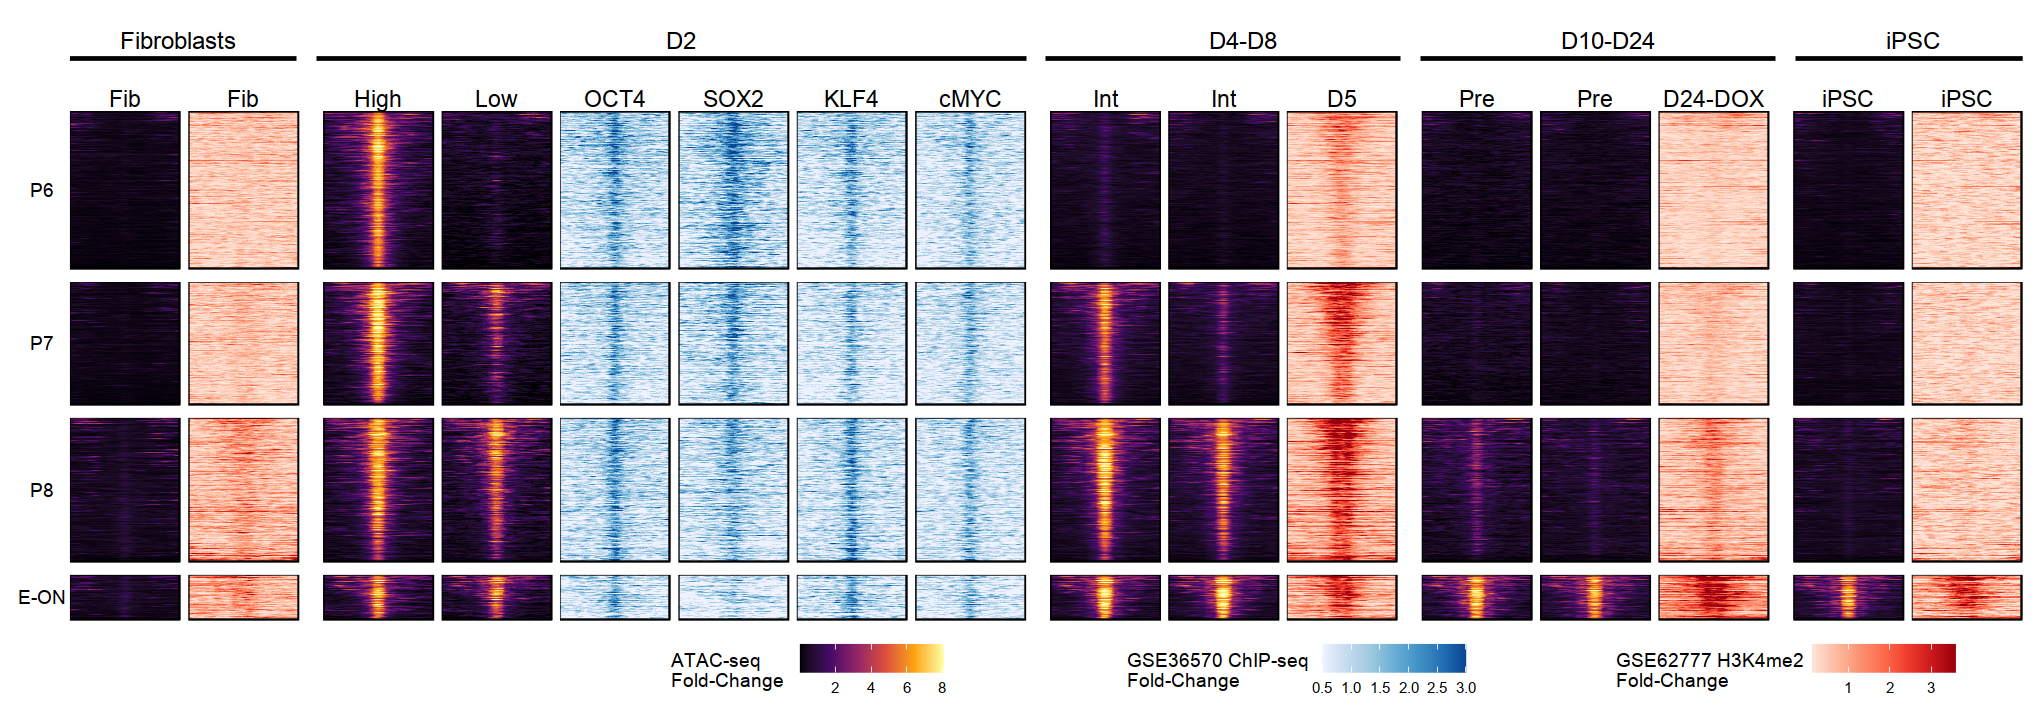

In [48]:
options(repr.plot.width = 17, repr.plot.height = 6)
vortex_grid = wrap_plots(
    rowwise_plots,
    ncol=1,
    heights = col_heights)

complete_plot = wrap_plots(top_annotate_plot,
                           vortex_grid,
                           legend_plot,
                           heights=c(1, 8, 1))
complete_plot

In [49]:
ggsave(sprintf("./subfigs/%s_vortex.pdf", format(Sys.Date(), "%Y%m%d")), 
       complete_plot, width=17,height=6)

In [ ]:
saveRDS(complete_plot, file=sprintf("./subfigs/%s_vortex.rds",
                                format(Sys.Date(), "%Y%m%d")))

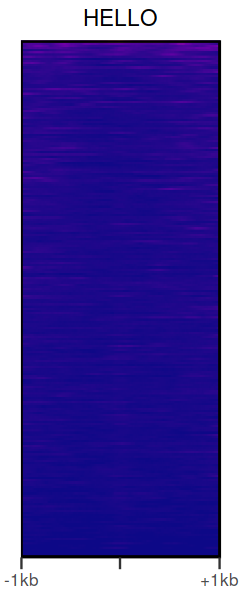

In [245]:
options(repr.plot.width = 2, repr.plot.height = 5)
plot_vortex(smoothed_matrices[[1]][[1]], 
            COLORSCALES[[as.numeric(vortex_config[1, "type"])]], 
            title="HELLO", ticks=1)